In [2]:
%matplotlib inline
import numpy as np
import scipy.io as scio
from scipy.io import loadmat
import pandas as pd
from pts_loader import load
import cv2
from matplotlib import pyplot as plt
import argparse
from imutils import face_utils
import imutils
import dlib
import cv2
import os
import sys
import math

In [5]:
x = loadmat('../model3D_aug_-00_00_01.mat')


In [6]:
x['model3D']

array([[(array([[[-130.00604248, -148.75372314,   65.006073  ],
        [-128.83235168, -148.75372314,   65.006073  ],
        [-127.65866089, -148.75372314,   65.006073  ],
        ...,
        [ 129.38014221, -148.75372314,   65.006073  ],
        [ 130.55383301, -148.75372314,   65.006073  ],
        [ 131.7275238 , -148.75372314,   65.006073  ]],

       [[-130.00604248, -147.58003235,   65.006073  ],
        [-128.83235168, -147.58003235,   65.006073  ],
        [-127.65866089, -147.58003235,   65.006073  ],
        ...,
        [ 129.38014221, -147.58003235,   65.006073  ],
        [ 130.55383301, -147.58003235,   65.006073  ],
        [ 131.7275238 , -147.58003235,   65.006073  ]],

       [[-130.00604248, -146.40634155,   65.006073  ],
        [-128.83235168, -146.40634155,   65.006073  ],
        [-127.65866089, -146.40634155,   65.006073  ],
        ...,
        [ 129.38014221, -146.40634155,   65.006073  ],
        [ 130.55383301, -146.40634155,   65.006073  ],
        [ 131

In [7]:
class FaceModel:
    def load_model(self, path, name):
        model = scio.loadmat(path)[name]
        self.out_A = np.asmatrix(model['outA'][0, 0], dtype='float32') #3x3
        self.size_U = model['sizeU'][0, 0][0] #1x2
        self.model_TD = np.asarray(model['threedee'][0,0], dtype='float32') #68x3
        self.indbad = model['indbad'][0, 0]#0x1
        self.ref_U = np.asarray(model['refU'][0,0])
        self.facemask = np.asarray(model['facemask'][0,0])
        self.facemask-=1 #matlab indexing

In [8]:
model = FaceModel()

In [10]:
model.load_model("../model3D_aug_-00_00_01.mat","model3D")

In [11]:
model.model_TD.shape

(68, 3)

In [12]:
def show_image(img):
    plt.axis("off")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
def get_landmarks_2d(img):
    img = imutils.resize(img, width=500)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)

    # loop over the face detections
    shape = None
    face = None
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        
        (x, y, w, h) = face_utils.rect_to_bb(rect)
        face = img[ y:y+h,x:x+w, :]
        gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
        
        shape = predictor(gray, rect)

        shape = face_utils.shape_to_np(shape)


    return shape, face


def get_6dovVector(im, points):
    size = im.shape

    #2D image points. If you change the image, you need to change vector
    image_points, face = get_landmarks_2d(im)
    image_points = points.astype(float)
    size = face.shape

    # 3D model points.
    model_points = model.model_TD
    
    # Camera internals

    focal_length = size[1]
    center = (size[1]/2, size[0]/2)
    camera_matrix = model.out_A

    print("Camera Matrix :\n {0}".format(camera_matrix))

    dist_coeffs = np.zeros((4,1)) # Assuming no lens distortion
    (success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs, cv2.SOLVEPNP_ITERATIVE)

    print("Rotation Vector:\n {0}".format(rotation_vector))
    print("Translation Vector:\n {0}".format(translation_vector))


    # Project a 3D point (0, 0, 1000.0) onto the image plane.
    # We use this to draw a line sticking out of the nose


    (nose_end_point2D, jacobian) = cv2.projectPoints(np.array([(0.0, 0.0, 1000.0)]), rotation_vector, translation_vector, camera_matrix, dist_coeffs)

    for p in image_points:
        cv2.circle(face, (int(p[0]), int(p[1])), 3, (0,0,255), -1)


    p1 = ( int(image_points[0][0]), int(image_points[0][1]))
    p2 = ( int(nose_end_point2D[0][0][0]), int(nose_end_point2D[0][0][1]))

    cv2.line(face, p1, p2, (255,0,0), 2)
    
    show_image(face)

In [13]:
shape_predictor = "../shape_predictor_68_face_landmarks.dat"
# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(shape_predictor)

In [16]:
validatio_set = pd.read_csv("../valid_set/validation_set.csv", index_col=0)

In [17]:
validatio_set

,file name,rx,ry,rz,tx,ty,tz
0,image_03219.png,0.232823,0.258984,0.179867,53.709269,76.402880,2496.058176
1,image_00402.png,-0.119785,0.362839,-0.062090,137.927724,115.523209,2427.485141
2,image_04501.png,0.107773,-0.038309,0.116286,148.894921,113.838309,2138.816636
3,image_08929.png,0.184916,-0.129779,0.049919,169.859404,74.267703,2098.792519
4,image_07866.png,0.151122,-0.300772,0.015359,66.115997,40.895412,2718.224083
...,...,...,...,...,...,...,...
95,image_02170.png,-0.213852,0.042669,0.231739,166.217478,41.252032,1710.019103
96,image_09896.png,0.194637,0.221584,-0.152009,116.124727,34.273149,2501.398260
97,image_02063.png,0.252662,0.055673,-0.146309,7.138096,27.443552,2463.320832
98,image_09568.png,0.088536,0.295496,0.001080,84.767566,102.915104,2971.355504


In [18]:
def get_6dovVector_lite(face, image_points):

    #2D image points. If you change the image, you need to change vector
    image_points = image_points.astype(float)

    # 3D model points.
    model_points = model.model_TD
    
    # Camera internals
    camera_matrix = model.out_A

    print("Camera Matrix :\n {0}".format(camera_matrix))

    dist_coeffs = np.zeros((4,1)) # Assuming no lens distortion
    (success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs, cv2.SOLVEPNP_ITERATIVE)

    print("Rotation Vector:\n {0}".format(rotation_vector))
    print("Translation Vector:\n {0}".format(translation_vector))


In [19]:
image_name = "image_02170"
# image_path = "./images/{}.png".format(image_name)
image_path = "../valid_set/images/{}.png".format(image_name)
image = cv2.imread(image_path)
path = "../valid_set/images/{}.pts".format(image_name)
points = np.array(load(path))

Camera Matrix :
 [[2.88e+03 0.00e+00 1.12e+02]
 [0.00e+00 2.88e+03 1.12e+02]
 [0.00e+00 0.00e+00 1.00e+00]]
Rotation Vector:
 [[-0.21385198]
 [ 0.04266889]
 [ 0.23173916]]
Translation Vector:
 [[ 166.21747818]
 [  41.25203162]
 [1710.01910332]]


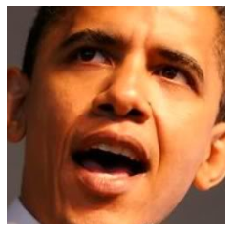

In [20]:
get_6dovVector(image, points)

In [21]:
def show_data(df):
    for i, it in enumerate(df['file name']):
        if image_name in it:
            return df.loc[i,:]

In [22]:
show_data(validatio_set)

file name    image_02170.png
rx                 -0.213852
ry                 0.0426689
rz                  0.231739
tx                   166.217
ty                    41.252
tz                   1710.02
Name: 95, dtype: object

## Generate data set

In [151]:
class pose_vanila:
    def __init__(self, camera_matrix, model_3d, detector, predictor):
        self.camera_matrix = camera_matrix
        self.model_3d = model_3d
        self.detector = detector
        self.predictor = predictor
    
    def _show_image(self, img):
        plt.axis("off")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.show()
        
    def get_landmarks_2d(self, image):
        image = image.copy()
        # under the assumption that my photos are easy to detect i am not going to
        # resize the image case it affects the output one rotating landmarks
#         if(max(image.shape[:2]) < 500):
#             image = imutils.resize(image, width=500)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        rects = self.detector(gray, 1)

        # loop over the face detections
        shape = None
        face = None
        for (i, rect) in enumerate(rects):
            # determine the facial landmarks for the face region, then
            # convert the facial landmark (x, y)-coordinates to a NumPy
            # array
            p = 0 # padding
            (x, y, w, h) = face_utils.rect_to_bb(rect)
            face = image[ y-p: y+h+p, x-p:x+w+p, :].copy()

            shape = self.predictor(gray, rect)
            shape = face_utils.shape_to_np(shape)
            
#             for (x, y) in shape:
#                 cv2.circle(image, (x ,y), 1, (0, 0, 255), -1)
                
#             self._show_image(image)

        return shape, face, image
    
    def calc_6dofVector(self, image_points):
       
        if(image_points is None):
            return None, None
        image_points = image_points.astype(float)

        # 3D model points.
        model_points = self.model_3d

        # Camera internals

        camera_matrix = self.camera_matrix

        dist_coeffs = np.zeros((4,1)) # Assuming no lens distortion
        (success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs, cv2.SOLVEPNP_ITERATIVE)

        if(rotation_vector is None or translation_vector is None):
            return None
        vector = [*rotation_vector, *translation_vector]

        return np.array(vector, dtype=np.float64).reshape(6)
    
    def predict(self, image, show=False):
        #2D image points. If you change the image, you need to change vector
        landmarks, face, original_image = self.get_landmarks_2d(image)
        
        vector = self.calc_6dofVector(landmarks)
        if(show):
            print("Rotation Vector:\n {0}".format(vector[:3]))
            print("Translation Vector:\n {0}".format(vector[3:]))
            self._show_image(face)
        
        return vector

In [146]:
t1 = pose_vanila( model.out_A, model.model_TD, detector, predictor)

Rotation Vector:
 [[ 0.12481755]
 [-0.03191794]
 [-0.01960182]]
Translation Vector:
 [[ -91.88310343]
 [ -69.16644918]
 [5466.53225906]]


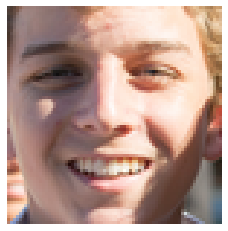

array([ 1.24817547e-01, -3.19179369e-02, -1.96018190e-02, -9.18831034e+01,
       -6.91664492e+01,  5.46653226e+03])

In [147]:
t1.predict(image, True)

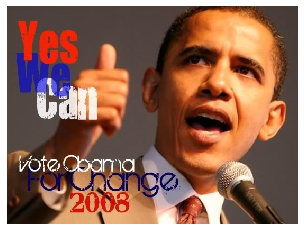

In [50]:
show_image(image)

Currently i was able to reproduce the same vector assuming i have the landmark points of the image.
That means thet i might get nice result using the vanila model but i am bounded by the face detector itself.
I should predict on the validation set with this vanila version, and check mse.
Afterwards I should try to generate adataset and check if i a deep model could be better.
In both situations i could try to improve the landmark detection in order to create a better dataset.

Conclustion:
1. check mse using vanila model on validation
2. genrate train set
3. evalute mse on validation using a model
4. decide if i should improve the face detector

** one option of optimaztion could be bounding box padding or more iterations of the detector

### Evaluate vanila method

In [51]:
def mse(a, b):
    mses = ((a-b)**2).mean()
    return mses

def cosine_similarity(a, b):
    dot = np.dot(a, b)
    norma = np.linalg.norm(a)
    normb = np.linalg.norm(b)
    cos = dot / (norma * normb)

    return cos

In [86]:
def generate_validation_set(df, file_dir):
    results = []
    for index, row in df.iterrows():
        file_name = row[0]
        file_path = os.path.abspath(file_dir.format(file_name))
        g_truth = np.array(row[1:], dtype=np.float64)
        
        results.append([file_path, g_truth])

    return np.array(results)

In [87]:
image_path = "../valid_set/images/{}"
v_set = generate_validation_set(validatio_set, image_path)

In [88]:
v_set_files = v_set[:,0]

In [89]:
v_set_files[0]

'/mnt/notebooks/Project - Pose/valid_set/images/image_03219.png'

In [95]:
def predict_on_files(files, model):
    results = []
    for file_path in files:
        image = cv2.imread(file_path)
        res = model.predict(image)
        if(res is not None):
            results.append([file_path, res])
    return np.array(results)

In [96]:
# prediction of files based on vanila model
y_predict = predict_on_files(v_set_files, t1)

In [97]:
def calc_loss(y_true, y_predict, func):
    sum_mses = 0
    valid_index_count = 0
    # normalizing the vectors using the biggest one among them
    max_t = np.array(y_true[:,1].tolist()).max(axis=0)
    max_prdeict = np.array(y_predict[:,1].tolist()).max(axis=0)
    max_vec = np.array([max_t, max_prdeict]).max(axis=0)

    for path, t_vec in y_true:
        for path_2, y_vec_2 in y_predict:        
            if(path == path_2 and t_vec is not None and y_vec_2 is not None):
                valid_index_count+=1
                t_vec = t_vec / max_vec
                y_vec_2 = y_vec_2 / max_vec
                sum_mses += func(t_vec[:3], y_vec_2[:3])
                
    return float(sum_mses)/ valid_index_count, valid_index_count
    

In [98]:
cosine, count = calc_loss(v_set, y_predict, cosine_similarity)

In [99]:
cosine

0.8673787125914947

In [100]:
mean_mse, count = calc_loss(v_set, y_predict, mse)

In [101]:
print("This mse score: {} is the error on the rotation vector, based on validation set and vanila model".format(mean_mse))

This mse score: 0.04192647059859142 is the error on the rotation vector, based on validation set and vanila model


### First attempt
https://www.kaggle.com/drgilermo/face-images-with-marked-landmark-points/data#

In [456]:
data = None


In [461]:
with np.load('./dataset/face_images.npz') as file_data:
    data = file_data['face_images']

In [464]:
data[:,:,1]

array([[219., 215., 204., ...,  92.,  88.,  84.],
       [222., 219., 220., ...,  92.,  88.,  86.],
       [231., 224., 212., ...,  77.,  80.,  84.],
       ...,
       [  1.,   1.,   1., ...,   1.,   1.,   1.],
       [  1.,   1.,   1., ...,   1.,   1.,   1.],
       [  1.,   1.,   1., ...,   1.,   1.,   1.]])

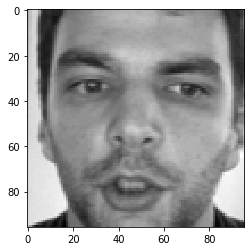

In [469]:

plt.imshow(data[:,:,98], interpolation='nearest', cmap='gray')
plt.show()

### Second dataset
https://github.com/NVlabs/ffhq-dataset
Trying this because it's with colors

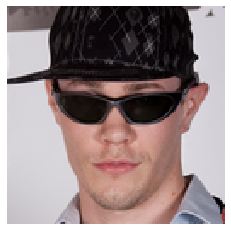

In [477]:
image_path = "./dataset/thumbnails128x128/07000/07442.png"
image = cv2.imread(image_path)
show_image(image)

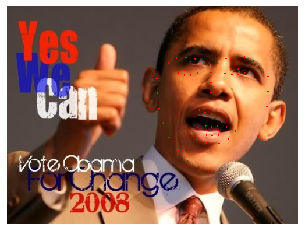

Rotation Vector:
 [[ 0.11267786]
 [ 0.10416926]
 [-0.02897192]]
Translation Vector:
 [[ 164.48447516]
 [  33.11534455]
 [1968.28359554]]


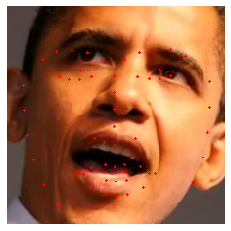

array([ 1.12677857e-01,  1.04169259e-01, -2.89719222e-02,  1.64484475e+02,
        3.31153446e+01,  1.96828360e+03])

In [865]:
t1.predict(image, True)

In [61]:
def grab_images(root_path, sampel=sys.maxsize):
    files_collection = []
    for root, dirs, files in os.walk(root_path, topdown=False):
        for name in files:
            files_collection.append(os.path.abspath(os.path.join(root, name)))
            if(len(files_collection) >= sampel):
                return files_collection
            
    return files_collection

In [164]:
vanila_model = pose_vanila( model.out_A, model.model_TD, detector, predictor)

In [137]:
def genrate_simple_trainning_data(root_path, sample, model):
    files = grab_images(root_path, sample)
    data = []
    
    for image_path in files:
        image = cv2.imread(image_path)
        vec_6dof = model.predict(image)
        if(vec_6dof is not None):
            data.append([image_path, *vec_6dof.tolist()])
        
    df = pd.DataFrame(data, columns = ['image_path', "rx","ry","rz","tx","ty","tz"]) 
    return df


In [64]:
t_set = genrate_simple_trainning_data("../dataset/thumbnails128x128/",100, vanila_model)

In [65]:
t_set

,image_path,rx,ry,rz,tx,ty,tz
0,/mnt/notebooks/Project - Pose/dataset/thumbnai...,0.149990,0.032534,-0.008162,-94.254265,-73.570178,5612.570498
1,/mnt/notebooks/Project - Pose/dataset/thumbnai...,0.048785,-0.086957,0.000416,-94.016053,-71.793168,5655.891028
2,/mnt/notebooks/Project - Pose/dataset/thumbnai...,0.204842,0.061677,0.002724,-89.728875,-72.011765,5477.579256
3,/mnt/notebooks/Project - Pose/dataset/thumbnai...,0.286556,0.014994,-0.007937,-91.611427,-72.648123,5518.430722
4,/mnt/notebooks/Project - Pose/dataset/thumbnai...,0.145421,-0.023829,-0.007007,-92.805020,-72.203525,5532.478848
...,...,...,...,...,...,...,...
92,/mnt/notebooks/Project - Pose/dataset/thumbnai...,0.227592,0.255542,0.062923,-85.029353,-69.752190,5297.760433
93,/mnt/notebooks/Project - Pose/dataset/thumbnai...,0.162203,-0.420179,-0.055591,-102.000772,-73.571817,5661.402206
94,/mnt/notebooks/Project - Pose/dataset/thumbnai...,-0.008967,0.111208,0.000555,-90.539561,-70.158129,5544.218322
95,/mnt/notebooks/Project - Pose/dataset/thumbnai...,0.090940,0.011197,0.013808,-80.622984,-59.267721,4887.727784


In [68]:
def to_vec(df):
    data = []
    for i, row in df.iterrows():
        data.append([row['image_path'],np.array([row["rx"],row["ry"],row["rz"]])])
    return data
    

In [69]:
training_set = to_vec(t_set)

#### Trying to choose vectors that are far from the center

In [253]:
vecs = np.array(training_set)[:,1]

In [254]:
mean = np.mean(vecs, axis=0)
sd = np.std(vecs, axis=0)
print("sd: {}, mean: {}".format(sd, mean))

sd: [0.12185878 0.18978061 0.54425533], mean: [ 0.05675815  0.03738856 -0.03808221]


In [566]:
final_list = [x for x in vecs if (np.any(np.greater(x ,mean - sd)))]
final_list = [x for x in final_list if (np.any(np.greater(mean + sd, x)))]

In [70]:
len(final_list)

NameError: name 'final_list' is not defined

### Trying to augment

In [165]:
class ImageAugmenter:
    def __init__(self, model):
        self.model = model
        
    def generate_sample(self, image, angle, scale=1.0):
        aug_image, landmarks = self._augment(image, angle, scale)
        dof_6_vec = self.model.calc_6dofVector(landmarks)
        return aug_image, dof_6_vec
        
    def _augment(self, image, angle, scale=1.0):
        image = image.copy()
        height, width = image.shape[:2]
        tx, ty = np.array((width // 2, height // 2))

        #generate affine matrix
        affine_matrix = cv2.getRotationMatrix2D((tx, ty), angle, scale)
        # get landmarks
        shape, face, original_image = self.model.get_landmarks_2d(image)
        # warped the image with the landmarks
        warped = cv2.warpAffine(src= original_image, M=affine_matrix, dsize=(0,0), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)

        #generate Humongous affine matrix
        h_affine_matrix = np.zeros((3,3))
        h_affine_matrix[:2,:] = affine_matrix

        # loop over the (x, y)-coordinates for the facial landmarks
        # and draw them on the image
        h_landmarks = np.ones((68, 3))
        h_landmarks[:,:2] = shape
        landmarks = []
        for i in range(68):
            x_tag = h_affine_matrix @ h_landmarks[i,:]
            landmarks.append(x_tag.tolist())

    #     for (x, y, z) in landmarks:
    #         cv2.circle(warped, (int(x), int(y)), 1, (0, 0, 255), -1)
    #     print(warped.shape)
    #     show_image(warped)
        landmarks = np.array(landmarks)[:,:2]
        return warped, landmarks
        

In [166]:
augmantor = ImageAugmenter(vanila_model)

In [167]:
training_set[0]

['/mnt/notebooks/Project - Pose/dataset/thumbnails128x128/07000/07062.png',
 array([ 0.14999004,  0.03253368, -0.00816207])]

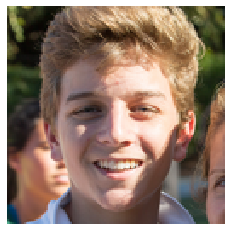

In [168]:
image_path = training_set[58][0]
image = cv2.imread(image_path)
show_image(image)

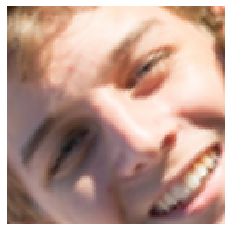

array([ 1.13959544e-01, -6.42955509e-02, -8.04879135e-01, -3.05930410e+01,
       -2.94996642e+01,  2.73623823e+03])

In [176]:
img, dof = augmantor.generate_sample(image, 45, 2)
show_image(img)
dof

In [171]:
print(vanila_model.predict(image))

[ 1.24817547e-01 -3.19179369e-02 -1.96018190e-02 -9.18831034e+01
 -6.91664492e+01  5.46653226e+03]


In [75]:
def rotate_and_validate(image, angle, scale=1):
    image = image.copy()
    height, width = image.shape[:2]
    tx, ty = np.array((width // 2, height // 2))
    
    #generate affine matrix
    affine_matrix = cv2.getRotationMatrix2D((tx, ty), angle, scale)
    # get landmarks
    shape, face, img = vanila_model._get_landmarks_2d(image)
    # warped the image with the landmarks
    warped = cv2.warpAffine(src= img, M=affine_matrix, dsize=(0,0), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    
    #generate Humongous affine matrix
    h_affine_matrix = np.zeros((3,3))
    h_affine_matrix[:2,:] = affine_matrix
    
    # loop over the (x, y)-coordinates for the facial landmarks
    # and draw them on the image
    h_landmarks = np.ones((68, 3))
    h_landmarks[:,:2] = shape
    landmarks = []
    for i in range(68):
        x_tag = h_affine_matrix @ h_landmarks[i,:]
        landmarks.append(x_tag.tolist())
    
#     for (x, y, z) in landmarks:
#         cv2.circle(warped, (int(x), int(y)), 1, (0, 0, 255), -1)
#     print(warped.shape)
#     show_image(warped)
    return np.array(landmarks)[:,:2]

(128, 128, 3)
(128, 128, 3)


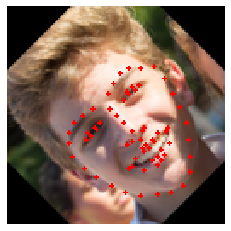

In [76]:
print(image.shape)
l = rotate_and_validate(image, 45)

In [262]:
l

array([[ 37.8370491 ,  83.09188309],
       [ 44.90811691,  88.74873734],
       [ 52.6862915 ,  95.11269837],
       [ 59.75735931, 100.76955262],
       [ 68.24264069, 103.59797975],
       [ 77.43502884, 105.71930009],
       [ 85.92031022, 105.71930009],
       [ 95.11269837, 105.01219331],
       [101.4766594 , 101.4766594 ],
       [107.13351365,  94.40559159],
       [109.96194078,  84.50609665],
       [112.08326112,  75.3137085 ],
       [111.37615434,  64.70710678],
       [108.54772721,  54.80761184],
       [102.89087297,  46.32233047],
       [ 95.81980515,  37.8370491 ],
       [ 88.74873734,  29.35176772],
       [ 36.42283553,  77.43502884],
       [ 36.42283553,  71.77817459],
       [ 40.66547622,  67.53553391],
       [ 45.61522369,  64.        ],
       [ 51.27207794,  61.17157288],
       [ 58.34314575,  54.10050506],
       [ 61.87867966,  47.73654403],
       [ 65.41421356,  41.372583  ],
       [ 71.07106781,  37.12994231],
       [ 78.8492424 ,  35.00862197],
 

In [202]:
image_name = "image_02170"
# image_path = "./images/{}.png".format(image_name)
image_path = "./valid_set/images/{}.png".format(image_name)
image = cv2.imread(image_path)


In [115]:
height, width = image.shape[:2]
tx, ty = np.array((width // 2, height // 2))
angle = np.radians(45)
scale = 1.0
R = np.array([
    [np.cos(angle), np.sin(angle), 0],
    [-np.sin(angle), np.cos(angle), 0],
    [0, 0, 1]
])
T = np.array([
    [1, 0, tx],
    [0, 1, ty],
    [0, 0, 1]
])
S = np.array([
    [scale, 0, 0],
    [0, scale, 0],
    [0, 0, 1]
])
A = T @ R @ S @ np.linalg.inv(T)


In [116]:
# Grid to represent image coordinate I(x, y)
coords = get_grid(width, height, True)
x1, y1 = coords[0], coords[1]

# Apply transformation and nearest neighbor interpolation
warp_coords = np.round(A@coords).astype(np.int)
x2, y2 = warp_coords[0, :], warp_coords[1, :]

# Get pixels within image
indices = np.where((x2 >= 0) & (x2 < width) &
                   (y2 >= 0) & (y2 < height))

xpix2, ypix2 = x2[indices], y2[indices]
xpix1, ypix1 = x1[indices].astype(int), y1[indices].astype(int)

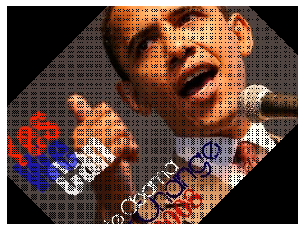

In [117]:
canvas = np.zeros_like(image)
canvas[ypix2, xpix2] = image[ypix1, xpix1]
show_image(canvas)

In [119]:
X = np.linalg.inv(A) @ X'
# set up pixel coordinate I'(x, y)
coords = get_grid(width, height, True)
x2, y2 = coords[0], coords[1]

# Apply inverse transform and round it (nearest neighbour interpolation)
warp_coords = (Ainv@coords).astype(np.int)
x1, y1 = warp_coords[0, :], warp_coords[1, :]

# Get pixels within image boundaries
indices = np.where((x1 >= 0) & (x1 < width) &
                   (y1 >= 0) & (y1 < height))

xpix1, ypix1 = x2[indices], y2[indices]
xpix2, ypix2 = x1[indices], y1[indices]

SyntaxError: EOL while scanning string literal (<ipython-input-119-ed6625570398>, line 1)

In [ ]:
# Map Correspondence
canvas = np.zeros_like(image)
canvas[ypix1, xpix1] = image[ypix2,xpix2]
show_image(canvas)

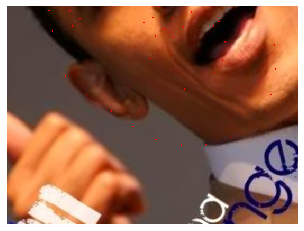

In [129]:
rotate_and_validate(image ,45)

## Test

In [66]:
def get_grid(x, y, homogenous=False):
    coords = np.indices((x, y)).reshape(2, -1)
    return np.vstack((coords, np.ones(coords.shape[1]))) if homogenous else coords

In [68]:
# Define Transformations
def get_rotation(angle):
    angle = np.radians(angle)
    return np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle),  np.cos(angle), 0],
        [0, 0, 1]
    ])
def get_translation(tx, ty):
    return np.array([
        [1, 0, tx],
        [0, 1, ty],
        [0, 0, 1]
    ])
def get_scale(s):
    return np.array([
        [s, 0, 0],
        [0, s, 0],
        [0, 0, 1]
    ])



In [75]:
R1 = get_rotation(0)
T1 = get_translation(0, 0)
S1 = get_scale(1)
coords = get_grid(128,128,True)


In [81]:

# Apply transformation x' = Ax

coords_trans = T1 @ S1 @R1 @coords

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 550 is different from 3)

In [80]:
plt.axis("off")
img = coords_trans
plt.imshow(img, cmap='gray')
plt.show()

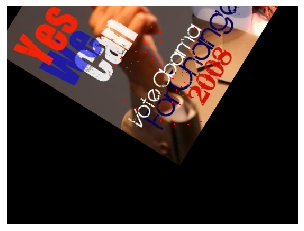

In [833]:
rotate_and_validate(45)

In [649]:
a = vanila_model._get_landmarks_2d(warped2)

In [801]:
np.transpose(A3) * a

array([[array([[-113.27465643, -263.46846013],
       [-118.3090856 , -283.60617683],
       [-125.02165783, -304.58296505],
       [-135.09051618, -323.88161022],
       [-145.99844606, -344.01932692],
       [-160.26266205, -363.31797209],
       [-180.40037875, -380.09940267],
       [-202.21623851, -390.16826102],
       [-226.54931285, -391.00733255],
       [-250.04331566, -382.61661726],
       [-268.5028893 , -367.51332974],
       [-284.44524836, -345.69746998],
       [-294.51410671, -322.20346717],
       [-297.87039282, -296.19224976],
       [-297.03132129, -271.02010389],
       [-292.83596365, -245.84795802],
       [-288.640606  , -221.51488368],
       [-120.82630019, -233.26188508],
       [-129.21701548, -226.54931285],
       [-141.80308841, -222.35395521],
       [-155.22823288, -221.51488368],
       [-168.65337734, -223.19302673],
       [-194.66459475, -213.96323991],
       [-206.41159615, -205.57252462],
       [-220.67581215, -200.53809545],
       [-235.7790

In [814]:
height, width = image.shape[:2]
tx, ty = np.array((width // 2, height // 2))
angle = np.radians(45)
scale = 1.0
R = np.array([
    [np.cos(angle), np.sin(angle), 0],
    [-np.sin(angle), np.cos(angle), 0],
    [0, 0, 1]
])
T = np.array([
    [1, 0, tx],
    [0, 1, ty],
    [0, 0, 1]
])
S = np.array([
    [scale, 0, 0],
    [0, scale, 0],
    [0, 0, 1]
])
A = T @ R @ S @ np.linalg.inv(T)

In [813]:
A

array([[   1.41421356,    1.41421356, -117.01933598],
       [  -1.41421356,    1.41421356,   64.        ],
       [   0.        ,    0.        ,    1.        ]])

In [671]:
h_a = np.ones((68, 3))
h_a[:,:2] = a[0]

In [826]:
h_a.shape


(68, 3)

In [828]:
A @ h_a[0]


array([252.372583  , 381.36248173,   1.        ])

In [633]:
def dotproduct(v1, v2):
    return sum((a*b) for a, b in zip(v1, v2))

def length(v):
    return math.sqrt(dotproduct(v, v))

def angle(v1, v2):
    return math.acos(dotproduct(v1, v2) / (length(v1) * length(v2)))


In [679]:
a[0].mean(axis=0)

array([239.98529412, 340.55882353])

### Generate test file

In [ ]:
<FILE_NAME, FACE_X, FACE_y, FACE_WIDTH, FACE_HEIGHT>


In [29]:
def get_face_box(img):
    img = imutils.resize(img, width=500)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)

    # loop over the face detections
    shape = None
    face = None
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        
        retuface_utils.rect_to_bb(rect)

In [33]:
image_box = get_face_box(image)

In [97]:
face_w, face_h, face_x, face_y = image_box
image_row = ( os.path.abspath(image_path), float(face_w), float(face_h), float(face_x), float(face_y))

In [98]:
df = pd.DataFrame([image_row], columns = ["FILE_NAME", "FACE_X", 'FACE_y', 'FACE_WIDTH', 'FACE_HEIGHT'])

In [99]:
df

,FILE_NAME,FACE_X,FACE_y,FACE_WIDTH,FACE_HEIGHT
0,/mnt/notebooks/Project - Pose/valid_set/images...,201.0,242.0,185.0,186.0


In [100]:
df.to_csv("./input_for_network.csv",index=False, header=False)

In [102]:
!cat input_for_network.csv

/mnt/notebooks/Project - Pose/valid_set/images/image_09568.png,201.0,242.0,185.0,186.0
